In [210]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "11" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 41
repetitionName =   "testJ3"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = True
if saveTop:
    saveTopName = "testp1rli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

39
4.333333333333333


In [211]:
import pandas as pd
from array import ArrayType
from requests import delete
from tabulate import tabulate
from prettytable import PrettyTable as pt
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 360)
(10, 360)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.23,0.23,0.215,0.26,0.255,0.225,0.2,0.205,0.25,0.25,0.245,0.275,0.545,0.555,0.545,0.565,0.555,0.605,0.4,0.335,0.36,0.68,0.645,0.665,0.665,0.665,0.675,0.55,0.595,0.63,0.26,0.245,0.255,0.66,0.54,0.62,0.5,0.505,0.52,0.495,0.545,0.56,0.305,0.32,0.46,0.27,0.255,0.215,0.205,0.145,0.195,0.225,0.25,0.23,0.415,0.41,0.435,0.23,0.22,0.225,0.295,0.25,0.255,0.685,0.64,0.66,0.66,0.665,0.675,0.55,0.595,0.635,0.205,0.19,0.19,0.425,0.435,0.455,0.43,0.435,0.5,0.48,0.515,0.54,0.275,0.265,0.38,0.215,0.245,0.255,0.245,0.24,0.225,0.375,0.405,0.38,0.44,0.485,0.47,0.32,0.285,0.3,0.665,0.635,0.65,0.675,0.665,0.68,0.57,0.605,0.625,0.195,0.265,0.225,0.415,0.435,0.385,0.44,0.465,0.5,0.45,0.495,0.54,0.315,0.33,0.405,0.295,0.28,0.275,0.385,0.375,0.44,0.2,0.195,0.25,0.3,0.24,0.3,0.685,0.675,0.66,0.66,0.66,0.67,0.55,0.59,0.645,0.215,0.225,0.24,0.44,0.4,0.47,0.5,0.465,0.54,0.525,0.525

In [212]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)
# for names in nameDict.keys():
#     print(names, end="        ")
#     x +=1
#     #print(x)



(1, 120)


,-fftData,-welchData,-dataHR,-dataCorr1d,-dataFFTCV-BC,-dataWCV-BC,-dataHRCV-BC,-fftDataBC,-welchDataBC,-dataHRBC,-gaussianData,-dataGCVBC,-gaussianDataBC,-dataCorr1dBC,-inverseFFT-BC,welchData--fftData,dataHR--fftData,dataCorr1d--fftData,dataFFTCV-BC--fftData,dataWCV-BC--fftData,dataHRCV-BC--fftData,fftDataBC--fftData,welchDataBC--fftData,dataHRBC--fftData,gaussianData--fftData,dataGCVBC--fftData,gaussianDataBC--fftData,dataCorr1dBC--fftData,inverseFFT-BC--fftData,dataHR--welchData,dataCorr1d--welchData,dataFFTCV-BC--welchData,dataWCV-BC--welchData,dataHRCV-BC--welchData,fftDataBC--welchData,welchDataBC--welchData,dataHRBC--welchData,gaussianData--welchData,dataGCVBC--welchData,gaussianDataBC--welchData,dataCorr1dBC--welchData,inverseFFT-BC--welchData,dataCorr1d--dataHR,dataFFTCV-BC--dataHR,dataWCV-BC--dataHR,dataHRCV-BC--dataHR,fftDataBC--dataHR,welchDataBC--dataHR,dataHRBC--dataHR,gaussianData--dataHR,dataGCVBC--dataHR,gaussianDataBC--dataHR,dataCorr1dBC--dataHR,inverseFFT-BC--dataHR,dataFFTCV-BC--dataCorr1d,dataWCV-BC--dataCorr1d,dataHRCV-BC--dataCorr1d,fftDataBC--dataCorr1d,welchDataBC--dataCorr1d,dataHRBC--dataCorr1d,gaussianData--dataCorr1d,dataGCVBC--dataCorr1d,gaussianDataBC--dataCorr1d,dataCorr1dBC--dataCorr1d,inverseFFT-BC--dataCorr1d,dataWCV-BC--dataFFTCV-BC,dataHRCV-BC--dataFFTCV-BC,fftDataBC--dataFFTCV-BC,welchDataBC--dataFFTCV-BC,dataHRBC--dataFFTCV-BC,gaussianData--dataFFTCV-BC,dataGCVBC--dataFFTCV-BC,gaussianDataBC--dataFFTCV-BC,dataCorr1dBC--dataFFTCV-BC,inverseFFT-BC--dataFFTCV-BC,dataHRCV-BC--dataWCV-BC,fftDataBC--dataWCV-BC,welchDataBC--dataWCV-BC,dataHRBC--dataWCV-BC,gaussianData--dataWCV-BC,dataGCVBC--dataWCV-BC,gaussianDataBC--dataWCV-BC,dataCorr1dBC--dataWCV-BC,inverseFFT-BC--dataWCV-BC,fftDataBC--dataHRCV-BC,welchDataBC--dataHRCV-BC,dataHRBC--dataHRCV-BC,gaussianData--dataHRCV-BC,dataGCVBC--dataHRCV-BC,gaussianDataBC--dataHRCV-BC,dataCorr1dBC--dataHRCV-BC,inverseFFT-BC--dataHRCV-BC,welchDataBC--fftDataBC,dataHRBC--fftDataBC,gaussianData--fftDataBC,dataGCVBC--fftDataBC,gaussianDataBC--fftDataBC,dataCorr1dBC--fftDataBC,inverseFFT-BC--fftDataBC,dataHRBC--welchDataBC,gaussianData--welchDataBC,dataGCVBC--welchDataBC,gaussianDataBC--welchDataBC,dataCorr1dBC--welchDataBC,inverseFFT-BC--welchDataBC,gaussianData--dataHRBC,dataGCVBC--dataHRBC,gaussianDataBC--dataHRBC,dataCorr1dBC--dataHRBC,inverseFFT-BC--dataHRBC,dataGCVBC--gaussianData,gaussianDataBC--gaussianData,dataCorr1dBC--gaussianData,inverseFFT-BC--gaussianData,gaussianDataBC--dataGCVBC,dataCorr1dBC--dataGCVBC,inverseFFT-BC--dataGCVBC,dataCorr1dBC--gaussianDataBC,inverseFFT-BC--gaussianDataBC,inverseFFT-BC--dataCorr1dBC
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.230000,0.260000,0.250000,0.275000,0.555000,0.605000,0.400000,0.680000,0.675000,0.630000,0.260000,0.660000,0.520000,0.560000,0.460000,0.270000,0.205000,0.250000,0.435000,0.230000,0.295000,0.685000,0.675000,0.635000,0.205000,0.455000,0.500000,0.540000,0.380000,0.255000,0.245

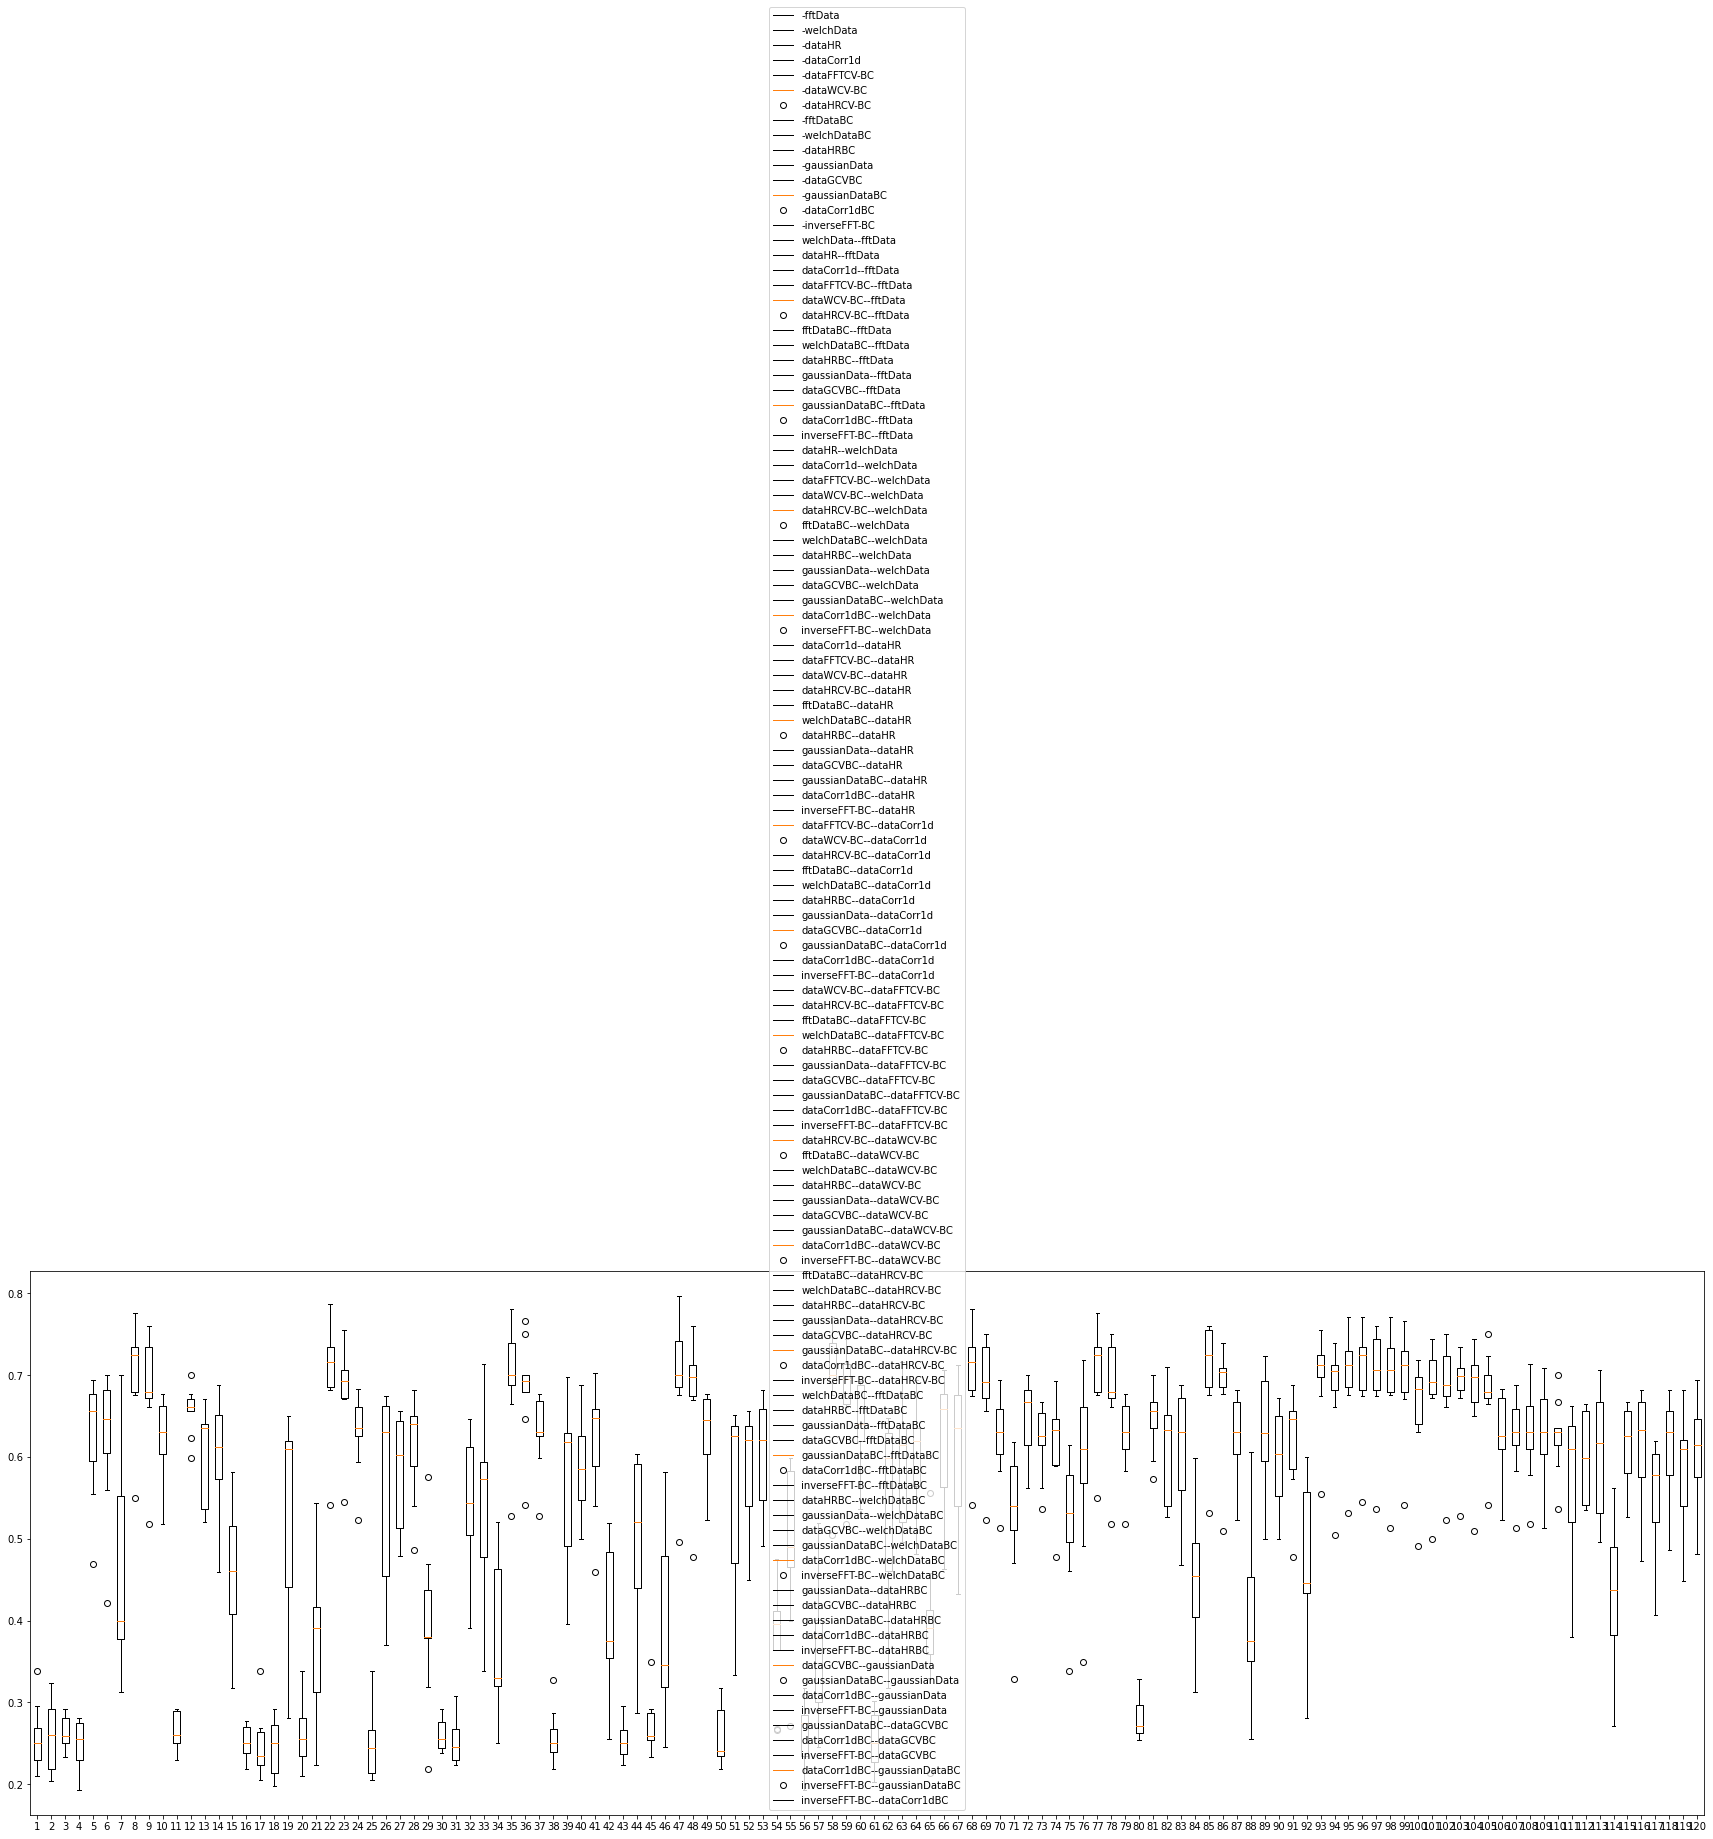

In [223]:
import matplotlib.pyplot as plt
# ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
# print(ordeTopAverage)
# print(len(combinationList))
# print(len(dataF))
# print(len(topPerFeature))
# print(len(combinationList)/len(dataF))
#print(ordeTopAverage)

#np.sort(topPerFeature, axis=1)
#np.argsort(comboAverage, axis=1)
#sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 200:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:])
    plt.legend(nameArray)
    print("")
# else: 
#     plt.figure(figsize=[30,10])
#     fig, ax = plt.subplots(figsize=[30,10])
#     plt.margins(y=1.5)
#     ax.set_ylim([np.min(topPerFeature[1:,ordeTopAverage[0][:topAmount]])-0.3,1])
#     plt.boxplot(topPerFeature[1:,ordeTopAverage[0][:topAmount]])
#     plt.legend(nameArray[ordeTopAverage[0][-topAmount:]])
#     plt.title(f"Best {topAmount} feature combos by average accuracy over subjects")
#     print(nameArray[ordeTopAverage[0][-topAmount:]])
    


In [214]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.8 : subject 5, feature:fftDataBC--dataHR, kernellinear, C:2.5
Accuracy 0.79 : subject 5, feature:fftDataBC--fftData, kernelrbf, C:2.5
Accuracy 0.78 : subject 5, feature:fftDataBC--welchData, kernelrbf, C:2.5
Accuracy 0.78 : subject 5, feature:fftDataBC--dataFFTCV-BC, kernelrbf, C:2.5
Accuracy 0.78 : subject 5, feature:fftDataBC--dataWCV-BC, kernelrbf, C:2.5
Accuracy 0.78 : subject 5, feature:-fftDataBC, kernelrbf, C:2.5
Accuracy 0.78 : subject 7, feature:fftDataBC--dataHR, kernelsigmoid, C:2.5
Accuracy 0.77 : subject 5, feature:fftDataBC--dataCorr1d, kernelrbf, C:2.5
Accuracy 0.77 : subject 5, feature:fftDataBC--dataCorr1d, kernellinear, C:2.5
Accuracy 0.77 : subject 5, feature:dataGCVBC--fftDataBC, kernelrbf, C:2.5


In [215]:
# top for each feature

In [216]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    skip = False  
    for obj in splitArray:
        #print(obj)
        if obj == "":
            #print("aofafa")
            skip = True
    if skip:
        continue
    #print(splitArray)
    newArrayOfTopFeatureNames.append(splitArray)
    
#print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
#saveTopName = "top2udrli"
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Top ten highest accuracies

Accuracy 0.8 : subject 5, feature:fftDataBC--dataHR, kernellinear, C:2.5

Accuracy 0.78 : subject 7, feature:fftDataBC--dataHR, kernelsigmoid, C:2.5

Accuracy 0.77 : subject 4, feature:welchDataBC--welchData, kernelsigmoid, C:2.5

Accuracy 0.76 : subject 8, feature:fftDataBC--dataHRCV-BC, kernellinear, C:2.5

Accuracy 0.75 : subject 2, feature:fftDataBC--dataCorr1d, kernelrbf, C:2.5

Accuracy 0.72 : subject 6, feature:gaussianDataBC--dataCorr1d, kernellinear, C:2.5

Accuracy 0.7 : subject 1, feature:dataHRBC--fftDataBC, kernelrbf, C:2.5

Accuracy 0.7 : subject 9, feature:welchDataBC--fftData, kernelrbf, C:2.5

Accuracy 0.62 : subject 3, feature:-dataGCVBC, kernellinear, C:2.5
TopFeatureNameArraySaved
[['fftDataBC' 'dataHR']
 ['fftDataBC' 'dataHR']
 ['welchDataBC' 'welchData']
 ['fftDataBC' 'dataHRCV-BC']
 ['fftDataBC' 'dataCorr1d']
 ['gaussianDataBC' 'dataCorr1d']
 ['dataHRBC' 'fftDataBC']
 ['welchDataBC' 'fftData']]


In [217]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.48880556 0.5428125  0.43510101 0.54688947 0.55792824
 0.5233428  0.53566262 0.56956597 0.45253183]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,0.226997,0.242022,0.235631,0.247186,0.224577,0.239152,0.241393,0.239329,0.239215,0.240793,0.233956,0.217677,0.611124,0.578933,0.607936,0.606791,0.535741,0.584573,0.424979,0.36963,0.452363,0.693874,0.677959,0.682706,0.656423,0.666355,0.67158,0.585774,0.611597,0.606543,0.254794,0.24634,0.213918,0.646471,0.610821,0.643573,0.537395,0.596294,0.578253,0.558157,0.600076,0.581751,0.298093,0.298277,0.448533,0.237555,0.218432,0.229539,0.237403,0.234335,0.228022,0.231218,0.235785,0.229491,0.496037,0.50451,0.519072,0.235793,0.242153,0.242109,0.361029,0.351515,0.360425,0.69101,0.683074,0.682508,0.652563,0.666218,0.676568,0.602767,0.614985,0.612201,0.231216,0.238104,0.223447,0.54173,0.552005,0.561846,0.545095,0.559939,0.566109,0.585783,0.594985,0.589198,0.279367,0.262388,0.39701,0.246122,0.250139,0.240812,0.237281,0.24246,0.231839,0.502957,0.515128,0.492128,0.501235,0.520482,0.51004,0.366858,0.351153,0.359901,0.680023,0.679836,0.68104,0.647064,0.669322,0.673672,0.598613,0.619484,0.613721,0.241879,0.235905,0.231913,0.536894,0.549312,0.543577,0.546669,0.561968,0.559975,0.576126,0.602864,0.587567,0.271543,0.266949,0.389108,0.254716,0.241002,0.224158,0.473681,0.477294,0.456444,0.244213,0.252422,0.246854,0.384754,0.341261,0.350231,0.692304,0.681955,0.678415,0.660875,0.666221,0.668952,0.596023,0.609327,0.614017,0.248268,0.243035,0.228382,0.533643,0.529777,0.523382,0.552515,0.563977,0.560495,0.567203,0.595833,0.584051,0.282887,0.278899,0.374838,0.463868,0.482622,0.438967,0.250053,0.241612,0.226648,0.36084,0.340896,0.334848,0.683348,0.675678,0.679379,0.652424,0.660718,0.658973,0.590133,0.614007,0.616829,0.23895,0.229912,0.215831,0.519665,0.534958,0.510002,0.561892,0.590867,0.544985,0.560431,0.588859,0.572995,0.275768,0.264914,0.386608,0.604815,0.582157,0.600303,0.577372,0.53069,0.593849,0.693866,0.675175,0.683611,0.660734,0.666892,0.67141,0.589604,0.611218,0.6083,0.470659,0.521065,0.505842,0.631077,0.626816,0.634327,0.541812,0.598316,0.599899,0.562551,0.607157,0.591797,0.472353,0.482207,0.498874,0.5727,0.546218,0.569335,0.693874,0.676875,0.682706,0.655911,0.665122,0.670852,0.585196,0.610335,0.606037,0.265673,0.26049,0.230023,0.62246,0.60637,0.633392,0.536614,0.604186,0.59065,0.558735,0.604577,0.583634,0.303302,0.302561,0.451313,0.694851,0.680389,0.678729,0.662917,0.671235,0.669941,0.5983,0.610128,0.61174,0.380825,0.373455,0.377574,0.604426,0.555396,0.61892,0.55763,0.577654,0.59133,0.572689,0.606761,0.596681,0.360781,0.368986,0.461019,0.677641,0.687306,0.669541,0.672612,0.668089,0.670074,0.694598,0.679604,0.677037,0.693392,0.675711,0.683916,0.691351,0.679901,0.682287,0.685025,0.681728,0.678215,0.688782,0.67012,0.673289,0.63347,0.65569,0.63829

Max average accuracy 0.6948505892255893


In [218]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC--dataHRCV-BC
linear
0.6948505892255893

gaussianData--fftDataBC
linear
0.694598063973064

-fftDataBC
linear
0.6938741582491583

fftDataBC--dataWCV-BC
linear
0.6938741582491583

fftDataBC--dataFFTCV-BC
linear
0.6938657407407408



In [219]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC--dataHRCV-BC
linear
0.6948505892255893

gaussianData--fftDataBC
linear
0.694598063973064

-fftDataBC
linear
0.6938741582491583

fftDataBC--dataWCV-BC
linear
0.6938741582491583

fftDataBC--dataFFTCV-BC
linear
0.6938657407407408



In [220]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,2.042973,2.178201,2.120682,2.224678,2.021193,2.152367,2.172538,2.153958,2.152936,2.16714,2.105606,1.959091,5.500114,5.210398,5.47142,5.461117,4.821667,5.261155,3.824811,3.326667,4.071269,6.244867,6.101629,6.144356,5.907803,5.997197,6.044223,5.27197,5.504375,5.458883,2.293144,2.217064,1.925265,5.818239,5.497386,5.792159,4.836553,5.366648,5.20428,5.023409,5.400682,5.235758,2.682841,2.684489,4.036799,2.137992,1.96589,2.065852,2.136629,2.109015,2.052197,2.080966,2.122064,2.065417,4.464337,4.540587,4.671648,2.12214,2.179375,2.178977,3.249261,3.163636,3.243826,6.219091,6.14767,6.142576,5.873068,5.995966,6.08911,5.424905,5.534867,5.509811,2.080947,2.142936,2.011023,4.875568,4.968049,5.05661,4.905852,5.039451,5.094981,5.272045,5.354867,5.302784,2.514299,2.361496,3.573087,2.215095,2.25125,2.167311,2.13553,2.18214,2.086553,4.52661,4.636155,4.429148,4.511117,4.684337,4.59036,3.301723,3.160379,3.23911,6.120208,6.118523,6.129356,5.82358,6.023902,6.063049,5.387519,5.57536,5.523485,2.176913,2.123144,2.087216,4.832045,4.943807,4.892197,4.920019,5.057708,5.039773,5.185133,5.425777,5.288106,2.443883,2.402538,3.50197,2.292443,2.169015,2.017424,4.263125,4.295644,4.107992,2.197917,2.271799,2.221686,3.462784,3.071345,3.152083,6.230739,6.137595,6.105739,5.947879,5.995985,6.020568,5.364205,5.483939,5.526155,2.234413,2.187311,2.055436,4.802784,4.767992,4.710436,4.972633,5.075795,5.044451,5.10483,5.3625,5.256458,2.545985,2.510095,3.373542,4.174811,4.343598,3.950701,2.250473,2.174508,2.03983,3.247557,3.068068,3.013636,6.150133,6.081098,6.114413,5.871818,5.946458,5.930758,5.311193,5.526061,5.551458,2.150549,2.069205,1.942481,4.676989,4.814621,4.590019,5.057027,5.317803,4.904867,5.043883,5.299735,5.156951,2.481913,2.384223,3.47947,5.443333,5.239413,5.402727,5.196345,4.776212,5.34464,6.244792,6.076572,6.1525,5.94661,6.002027,6.042689,5.306439,5.500966,5.474697,4.235928,4.689583,4.552576,5.679697,5.641345,5.708939,4.876307,5.384848,5.399091,5.062955,5.464413,5.326174,4.251174,4.339867,4.489867,5.154299,4.915966,5.124015,6.244867,6.091875,6.144356,5.903201,5.986098,6.03767,5.266761,5.493011,5.454337,2.391061,2.344413,2.070208,5.60214,5.45733,5.70053,4.829527,5.43767,5.315852,5.028617,5.441193,5.252708,2.729716,2.723049,4.061818,6.253655,6.123504,6.108561,5.96625,6.041117,6.02947,5.384697,5.491155,5.505663,3.427424,3.361098,3.398163,5.43983,4.998561,5.570284,5.018674,5.198883,5.32197,5.154205,5.460852,5.370133,3.247027,3.320871,4.149167,6.098769,6.185758,6.025871,6.053504,6.012803,6.030663,6.251383,6.116439,6.093333,6.24053,6.081402,6.155246,6.222159,6.11911,6.140587,6.165227,6.135549,6.103939,6.199034,6.03108,6.059602,5.701231,5.901212,5.74464,5.96085

252
9.0
Max total significant accuracy then averaged 0.6948505892255893 
fftDataBC--dataHRCV-BC
linear
C: 2.5 


In [221]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
